In [2]:
from sklearn import datasets 
import matplotlib.pyplot as plt 
import seaborn as sns
import math
import numpy as np
from scipy import stats
from tqdm import tqdm

data = datasets.load_iris()
data.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [3]:
data['target_names'] , data['feature_names']

(array(['setosa', 'versicolor', 'virginica'], dtype='<U10'),
 ['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'])

In [4]:
X,Y = data['data'],data['target']

# Sklearn Decision Tree

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
model = DecisionTreeClassifier(criterion= 'entropy',
                       max_depth = 5,min_impurity_split= 1e-7,random_state=11)
model.fit(X,Y)
accuracy_score(Y,model.predict(X))

c:\users\clive\appdata\local\programs\python\python37\lib\site-packages\sklearn\tree\_classes.py:301: FutureWarning: The min_impurity_split parameter is deprecated. Its default value will change from 1e-7 to 0 in version 0.23, and it will be removed in 0.25. Use the min_impurity_decrease parameter instead.
  FutureWarning)


1.0

In [13]:
model.classes_

array([0, 1, 2])

In [14]:
model.feature_importances_

array([0.0115876 , 0.        , 0.07765342, 0.91075898])

In [15]:
model.max_features_

4

In [19]:
model.tree_.

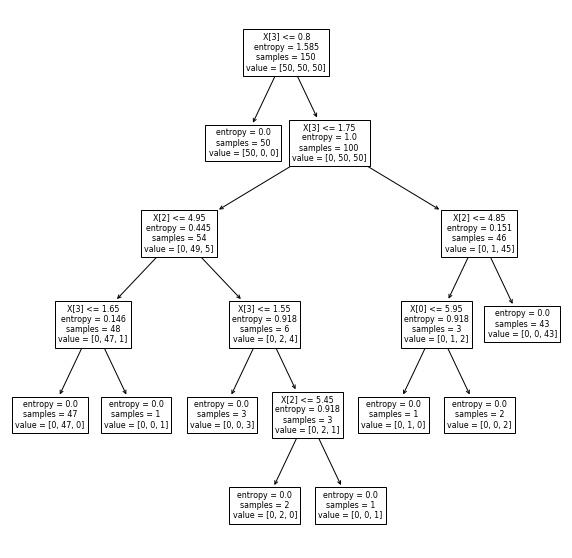

In [25]:
import matplotlib.pyplot as plt 

plt.figure(figsize =  (10,10))
tree.plot_tree(model);

In [6]:
class DecisionNode:
    
    def __init__(self,feature = None,
                     entropy = None,threshold = None,
                     value = None,right=None,left=None):   
            
            self.entropy = entropy
            
            self.feature = feature
             
            self.right = right
            
            self.left = left
            
            self.threshold = threshold
            
            self.value = value

# function to find feature to split on 
#method from https://github.com/eriklindernoren/ML-From-Scratch#evolutionary-evolved-neural-network
def divide_on_feature(X, feature_i, threshold):

    split_func = None
    if isinstance(threshold, int) or isinstance(threshold, float):
        split_func = lambda sample: sample[feature_i] >= threshold
    else:
        split_func = lambda sample: sample[feature_i] == threshold

    X_1 = np.array([sample for sample in X if split_func(sample)])
    X_2 = np.array([sample for sample in X if not split_func(sample)])

    return np.array([X_1, X_2])


def entropy(y):
    
    classes = np.unique(y) # 1 2 3
    length = len(y)
    entropy = 0
    for label in classes:
        p = np.sum(y == label) / length
        entropy += p * np.log2(p)
        
    return -entropy


def gini_index(y):
    
    # formula : 1 - p+ ^ 2 - p-^2 
    
    classes = np.unique(y) # 1 2 3
    length = len(y)
    gini = 1
    proba = 0
    for label in classes:
        p = np.sum(y == label) / length
        proba += p **2
        
    return gini - proba

    
    

    
def majority_vote(y):
    
        most_common = None
        max_count = 0
        for label in np.unique(y):
            # Count number of occurences of samples with label
            count = len(y[y == label])
            if count > max_count:
                most_common = label
                max_count = count
        return most_common

    

class DecisionTreeClassifier:
    
    
    def __init__(self, min_samples_split=3, min_impurity=1e-7,
                 max_depth= 5,criterian = 'entropy'):
        
        #contains the root of the tree 
        self.root = None         
        self.criterian = criterian
        #stopping conditions 
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        
        
        
        
    def fit(self,X,y):

        
        print(f'Shape of dataset :: {X.shape}')
        
        self.root  = self._build_tree(X,y)
        
    
        
    def _build_tree(self, X, y, current_depth=0):
 
        largest_impurity = 0
        best_criteria = None    # Feature index and threshold
        best_sets = None     # Subsets of the data
        right = None 
        left= None
        selected_feature = None
        selected_threshold = None
        
        # Check if expansion of y is needed
        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)

        # Add y as last column of X
        Xy = np.concatenate((X, y), axis=1)

        n_samples, n_features = np.shape(X)

        
        if n_samples >= self.min_samples_split and self.max_depth >= current_depth:

            for feature_i in range(n_features):
                
                # All values of feature_i
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)

     
                for threshold in unique_values:
                  
                
                    Xy1, Xy2 = divide_on_feature(Xy, feature_i, threshold)

                    if len(Xy1) > 0 and len(Xy2) > 0:
                        # Select the y-values of the two sets
                        y1 = Xy1[:,-1]
                        y2 = Xy2[:,-1]

                        impurity = self.info_gain(y, y1, y2)

                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            selected_feature = feature_i
                            selected_threshold = threshold 
                            right,left = Xy2,Xy1
    
    
        if largest_impurity > self.min_impurity:
            # Build subtrees for the right and left branches
            left = self._build_tree(left[:,:-1], left[:,-1], current_depth = current_depth + 1)
            right = self._build_tree(right[:,:-1], right[:,-1], current_depth = current_depth + 1)
            return DecisionNode(feature=selected_feature, threshold=selected_threshold, left=left, right=right)

        # We're at leaf => determine value
        leaf_value = majority_vote(y)

        return DecisionNode(value=leaf_value)
    
    
    
    def get_imputiry_metric(self):
        
        if self.criterian == 'entropy':
            return entropy
        else:
            return gini_index
            
    
    def info_gain(self,y,y1,y2):
    
        p = len(y1) / len(y)
              
        criterian = self.get_imputiry_metric()

        ent = criterian(y)

        info_gain = ent - p * criterian(y1) - (1 - p) * criterian(y2)

        return info_gain
    
    
    
    

    def predict_value(self, x, tree=None):
        

        if tree is None:
            tree = self.root

        if tree.value is not None:
            return tree.value

        feature_value = x[tree.feature]

        # Determine if we will follow left or right branch
        branch = tree.right
        if isinstance(feature_value, int) or isinstance(feature_value, float):
            if feature_value >= tree.threshold:
                branch = tree.left
        elif feature_value == tree.threshold:
            branch = tree.left


        # Test subtree
        return self.predict_value(x, branch)

        
    def predict(self,X):
        
        y_pred = [self.predict_value(sample) for sample in X]
         
        return y_pred
        
      
m  = DecisionTreeClassifier(criterian = 'gini')        
m.fit(X,Y)
accuracy_score(Y,m.predict(X))

Shape of dataset :: (150, 4)


1.0